In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [ ]:
from transformers import TFAutoModel, AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the dataset
file_path = 'combined_Dataset.xlsx'
df = pd.read_excel(file_path)


In [ ]:
df

,Commands,Intent
0,Turn off all the fans,all fans off
1,Switch off all the fans,all fans off
2,Power down all the fans,all fans off
3,Shut off all the fans,all fans off
4,Deactivate all the fans,all fans off
...,...,...
5395,Room1 lights need to be activated instantly.,room1 light off
5396,Please ensure that room1 lights are off right ...,room1 light off
5397,Room1's lights should be turned off immediately.,room1 light off
5398,"Turn off the lights in room1 instantly, please.",room1 light off


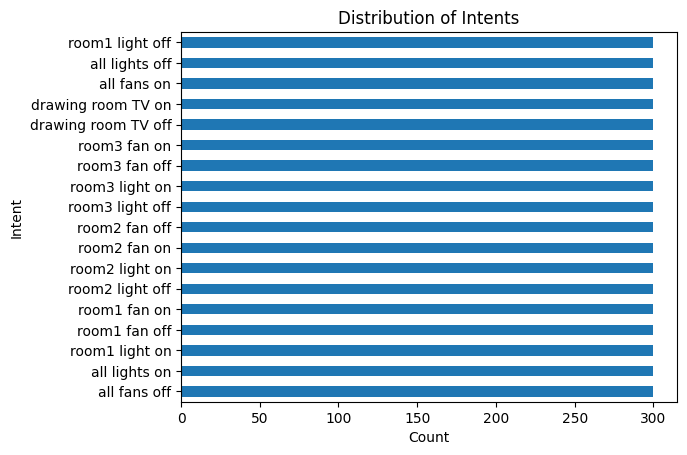

In [ ]:
# @title Distribution of intents

import matplotlib.pyplot as plt

df['Intent'].value_counts().plot(kind='barh')
plt.title('Distribution of Intents')
plt.xlabel('Count')
_ = plt.ylabel('Intent')

In [ ]:
len(df['Intent'].unique())

18

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

In [ ]:
df['encoded_intent'] = df['Intent'].astype('category').cat.codes

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize data
def tokenize_function(examples):
    return tokenizer(examples['Commands'], padding='max_length', truncation=True, max_length=16)

# Apply tokenizer
train_encodings = df['Commands'].apply(lambda x: tokenizer.encode_plus(x, max_length=16, padding='max_length', truncation=True, return_tensors="tf"))

# Extract input_ids and attention_mask
input_ids = tf.constant([enc['input_ids'].numpy()[0] for enc in train_encodings])
attention_masks = tf.constant([enc['attention_mask'].numpy()[0] for enc in train_encodings])
labels = tf.constant(df['encoded_intent'].values)

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': input_ids, 'attention_mask': attention_masks}, labels))

# Shuffle and split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset = dataset.take(train_size).batch(2)
val_dataset = dataset.skip(train_size).take(val_size).batch(2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
df.to_excel("new_data.xlsx")

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=18)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/30
2160/2160 [==============================] - 130s 47ms/step - loss: 0.6853 - accuracy: 0.8759 - val_loss: 5.9646 - val_accuracy: 0.1667
Epoch 2/30
2160/2160 [==============================] - 94s 43ms/step - loss: 0.4285 - accuracy: 0.9118 - val_loss: 7.6154 - val_accuracy: 0.1667
Epoch 3/30
2160/2160 [==============================] - 93s 43ms/step - loss: 0.3247 - accuracy: 0.9252 - val_loss: 8.8123 - val_accuracy: 0.1667
Epoch 4/30
2160/2160 [==============================] - 92s 43ms/step - loss: 0.2818 - accuracy: 0.9347 - val_loss: 9.5286 - val_accuracy: 0.1667
Epoch 5/30
2160/2160 [==============================] - 92s 43ms/step - loss: 0.2806 - accuracy: 0.9333 - val_loss: 10.3904 - val_accuracy: 0.1667
Epoch 6/30
2160/2160 [==============================] - 93s 43ms/step - loss: 0.2778 - accuracy: 0.9331 - val_loss: 11.3159 - val_accuracy: 0.1667
Epoch 7/30
2160/2160 [==============================] - 97s 45ms/step - loss: 0.3175 - accuracy: 0.9183 - val_loss: 11.59

In [ ]:
# Evaluate the model on the validation set
val_results = model.evaluate(val_dataset)
print(f"Validation loss: {val_results[0]}")
print(f"Validation accuracy: {val_results[1]}")



# Function to predict intent
def predict_intent(command):
    encodings = tokenizer.encode_plus(command, max_length=16, padding='max_length', truncation=True, return_tensors="tf")
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    logits = model.predict({'input_ids': input_ids, 'attention_mask': attention_mask}).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    return predicted_class

# Test the prediction function
test_command = "Can you please turn on the fan of room 1"
predicted_intent = predict_intent(test_command)
print(f"Predicted intent for '{test_command}': {predicted_intent}")

540/540 [==============================] - 15s 28ms/step - loss: 22.3784 - accuracy: 0.1667
Validation loss: 22.37839126586914
Validation accuracy: 0.1666666716337204
1/1 [==============================] - 7s 7s/step
Predicted intent for 'Can you please turn on the fan of room 1': 9


In [ ]:
# Function to preprocess data
def preprocess(data, tokenizer):
    return tokenizer(data['Commands'], truncation=True, padding='max_length', max_length=128)


In [ ]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=18)


In [ ]:
# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
# Tokenize data
train_dataset = train_dataset.map(lambda x: preprocess(x, tokenizer), batched=True)
val_dataset = val_dataset.map(lambda x: preprocess(x, tokenizer), batched=True)
test_dataset = test_dataset.map(lambda x: preprocess(x, tokenizer), batched=True)

In [ ]:
  # Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
!pip install accelerate -U`

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate==0.21.0

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduce batch size
    per_device_eval_batch_size=8,  # Reduce batch size
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    gradient_accumulation_steps=2,  # Accumulate gradients
)

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [ ]:
# Train the model
trainer.train()
